In [ ]:
# Instalação das dependências
!pip install fastf1 seaborn matplotlib --quiet

In [2]:
# Importação das bibliotecas
import seaborn as sns
from matplotlib import pyplot as plt
import fastf1
import fastf1.plotting
import pandas as pd

In [3]:
# Habilitar cache (no Colab, foi criada uma pasta persistente)
import os
if not os.path.exists('/content/cache'):
    os.makedirs('/content/cache')
fastf1.Cache.enable_cache('/content/cache')

In [4]:
# Configurar esquema de cores do FastF1
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, color_scheme='fastf1')

In [5]:
# Lista dos GPs disponíveis por ano para busca de dados
year = 2024
schedule = fastf1.get_event_schedule(year)

print(schedule[['RoundNumber', 'EventName', 'EventDate']])

    RoundNumber                  EventName  EventDate
0             0         Pre-Season Testing 2024-02-23
1             1         Bahrain Grand Prix 2024-03-02
2             2   Saudi Arabian Grand Prix 2024-03-09
3             3      Australian Grand Prix 2024-03-24
4             4        Japanese Grand Prix 2024-04-07
5             5         Chinese Grand Prix 2024-04-21
6             6           Miami Grand Prix 2024-05-05
7             7  Emilia Romagna Grand Prix 2024-05-19
8             8          Monaco Grand Prix 2024-05-26
9             9        Canadian Grand Prix 2024-06-09
10           10         Spanish Grand Prix 2024-06-23
11           11        Austrian Grand Prix 2024-06-30
12           12         British Grand Prix 2024-07-07
13           13       Hungarian Grand Prix 2024-07-21
14           14         Belgian Grand Prix 2024-07-28
15           15           Dutch Grand Prix 2024-08-25
16           16         Italian Grand Prix 2024-09-01
17           17      Azerbai

In [6]:
# Configuração dos dados da sessão

# Session Names
#
# FP1 → Treino Livre 1
# FP2 → Treino Livre 2
# FP3 → Treino Livre 3
# Q ou "Qualifying" → Classificação
# SQ ou "Sprint Qualifying" → Qualificação da Sprint
# S ou "Sprint" → Corrida Sprint
# R ou "Race" → Corrida principal

year = 2024
gp = "Singapore"
session_type = "Race"
title = f"{year} {gp} {session_type} - Distribuição de Voltas Rápidas"

In [7]:
# Carregar sessão

session = fastf1.get_session(year, gp, session_type)
session.load()

# Selecionar apenas voltas rápidas (descartando in/out laps)
laps = session.laps.pick_quicklaps()

# print(laps)

core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:55:59.335' in Ergastresponse.
req            INFO 	No cached data found for session_status_da

In [8]:
# Obtém a ordem dos pilotos pela média ou mediana dos seus tempos de volta

transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# Ordenar pilotos do mais rápido (mediana/média menor) ao mais lento
driver_order = (
    transformed_laps[["Driver", "LapTime (s)"]]
    .groupby("Driver")
    .mean()["LapTime (s)"] # por média
    # .median()["LapTime (s)"] # por mediana
    .sort_values()
    .index
)
print("Ordem dos pilotos (do mais rápido ao mais lento):")
print(driver_order)


Ordem dos pilotos (do mais rápido ao mais lento):
Index(['NOR', 'VER', 'PIA', 'LEC', 'RUS', 'HAM', 'SAI', 'ALO', 'HUL', 'COL',
       'TSU', 'PER', 'RIC', 'MAG', 'GAS', 'STR', 'OCO', 'ALB', 'ZHO', 'BOT'],
      dtype='object', name='Driver')


In [9]:
# Configura cores para os pilotos usando a lista obtida em driver_order

driver_palette = {
    drv: fastf1.plotting.get_driver_color(drv, session=session)
    for drv in driver_order
}


req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


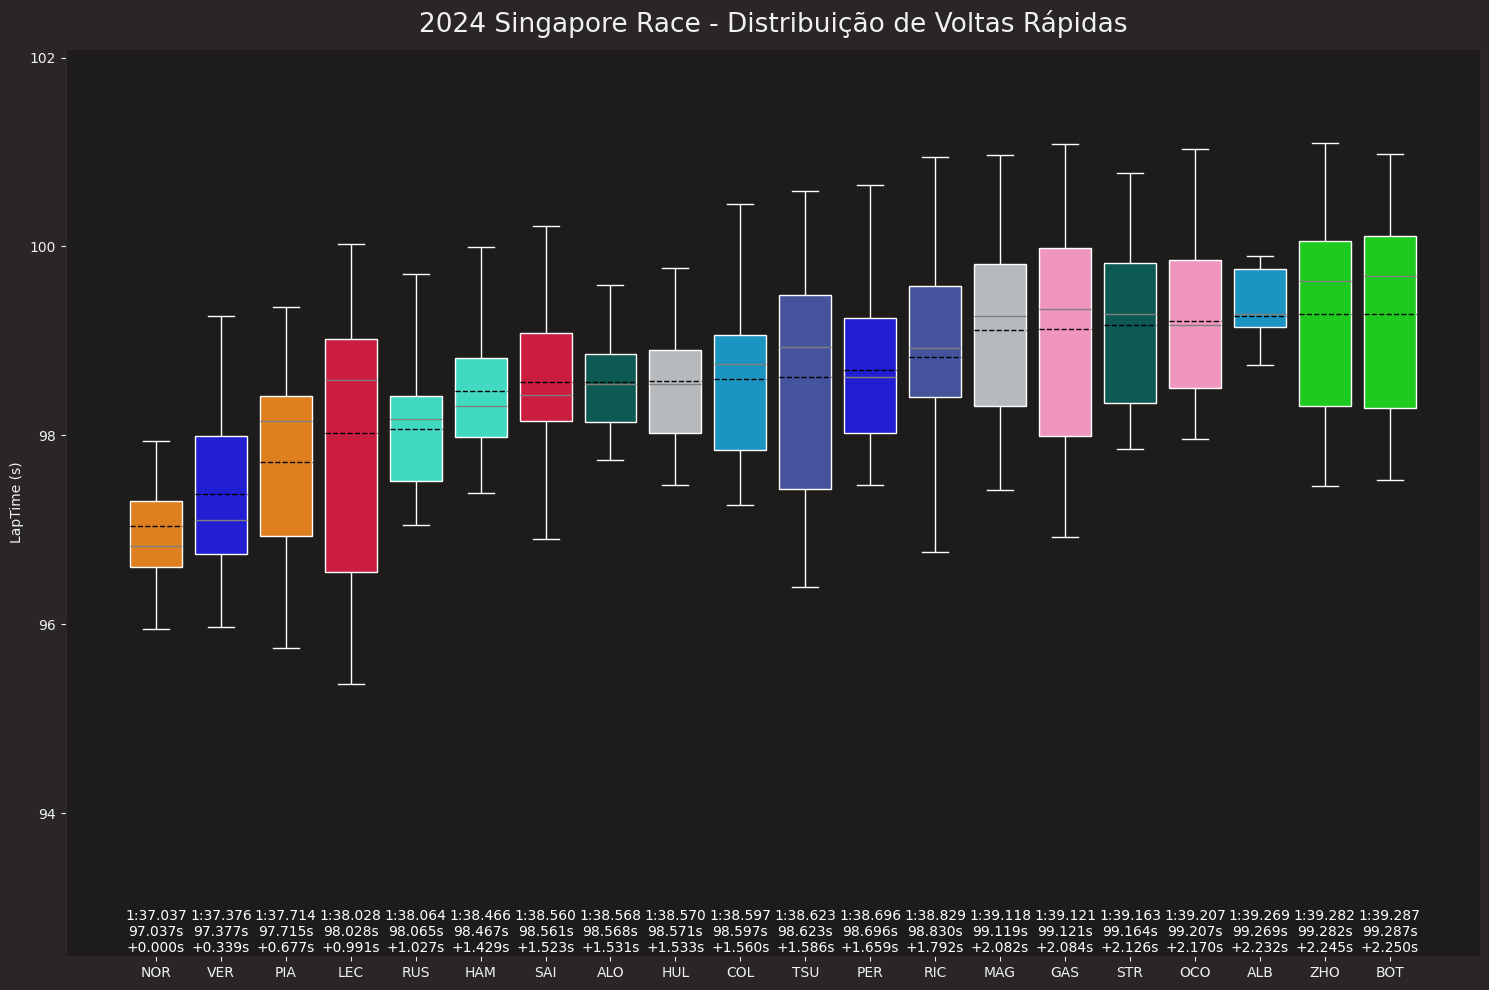

In [10]:
# Plotar boxplot

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(
    data=transformed_laps,
    x="Driver",
    y="LapTime (s)",
    hue="Driver",
    order=driver_order,
    palette=driver_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

# Calcular médias por piloto
means = transformed_laps.groupby("Driver")["LapTime (s)"].mean()

# Adicionar linha tracejada em cada piloto (posição x = índice do driver)
for i, driver in enumerate(driver_order):
    mean = means[driver]
    ax.plot(
        [i - 0.4, i + 0.4],   # largura da linha tracejada
        [mean, mean],         # posição em Y (média)
        color="black",
        linestyle="--",
        linewidth=1
    )


# Calcular diferença para o piloto à frente
# diff_to_next = []
# for i, driver in enumerate(driver_order):
#     mean = means[driver]
#     if i == 0:
#         diff_to_next.append(0)
#     else:
#         diff = mean - means[driver_order[i-1]]  # pega o piloto à frente pela mesma ordem
#         diff_to_next.append(diff)
#     # print(f"{driver}: {mean:.3f}s - diff = {diff_to_next[-1]:.3f}s")

# Calcular diferença para o piloto mais rápido
diff_to_first = []
for i, driver in enumerate(driver_order):
    mean = means[driver]
    if i == 0:
        diff_to_first.append(0)
    else:
        diff = mean - means[driver_order[0]]
        diff_to_first.append(diff)
    # print(f"{driver}: {mean:.3f}s - diff = {diff_to_first[-1]:.3f}s")

# Função para formatar segundos em min:seg.ms
def format_laptime_to_mm_ss_ms(seconds: float) -> str:
    if pd.isna(seconds):
        return "-"
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 1000)
    return f"{minutes}:{sec:02d}.{ms:03d}"

# Calcular tempos de volta em mm:ss.ms
formatted_lap_time = []
for i, driver in enumerate(driver_order):
    mean = means[driver]
    formatted_lap_time.append(format_laptime_to_mm_ss_ms(mean))
    # print(f"{driver}: {mean:.3f}s - diff = {formatted_lap_time[i]}s")

# Adicionar texto abaixo do eixo X
y_min = transformed_laps["LapTime (s)"].min()  # menor tempo de volta
y_text = y_min - 1.5  # ajustar para ficar abaixo do gráfico

for i, driver in enumerate(driver_order):
    mean = means[driver]
    diff = diff_to_first[i]
    formatted = formatted_lap_time[i]

    ax.text(
        i,                    # posição X
        y_text,               # posição Y
        f"{formatted}\n{mean:.3f}s\n+{diff:.3f}s",  # texto: média + distância
        ha='center',          # centralizado horizontalmente
        va='top',             # alinhar verticalmente acima do ponto
        fontsize=10,
        color='white'
    )

plt.title(title)
plt.grid(visible=False)

# Remover label redundante
ax.set(xlabel=None)

# Expandir limites do eixo Y para caber o texto
ax.set_ylim(y_text - 0.5, transformed_laps["LapTime (s)"].max() + 1)

plt.tight_layout()
plt.show()

# Análises
#
# Se a média e a mediana estão próximas → piloto foi consistente.
# Se estão afastadas → o piloto teve algumas voltas muito lentas/rápidas que puxaram a média.